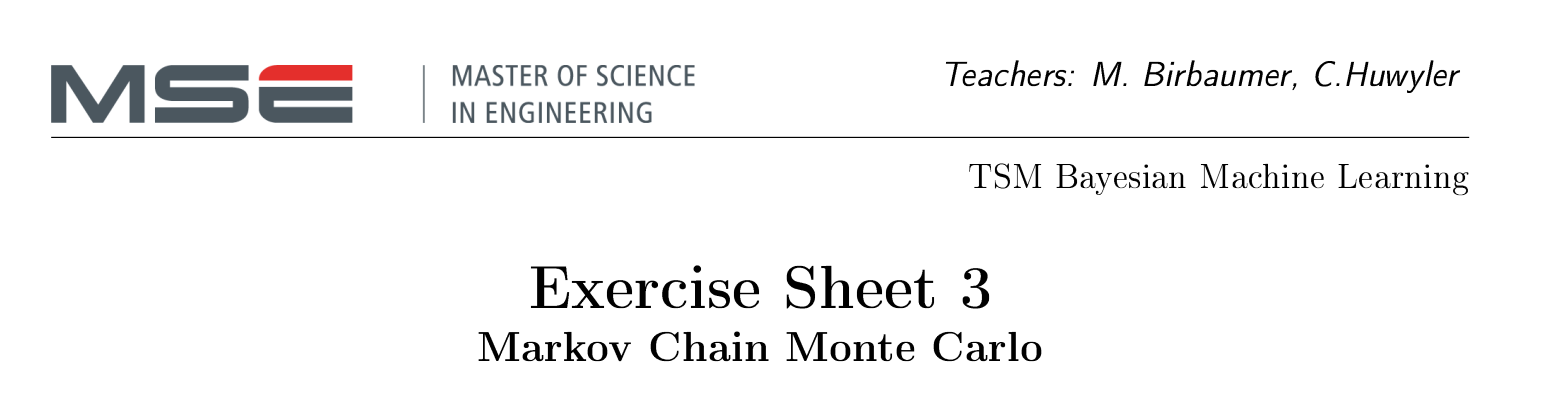

# Solutions

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
from tqdm.auto import tqdm
plt.rcParams["figure.figsize"] = (15,3)
plt.style.use('ggplot')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Exercise 1

Problem definition:

In [2]:
alpha = 5
beta = 2
n = 10
k = 8

### a) Proposal distribution

In [3]:
def propose_jump( pi, sigma ):
    return stats.norm.rvs( loc=pi, scale=sigma )

propose_jump( 0.3, 0.1 )

0.24117921109158258

### b) Random walk

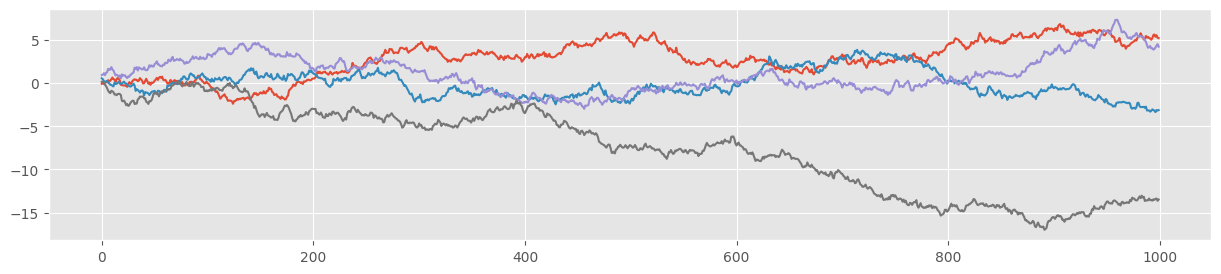

In [4]:
def plot_random_walk( sigma=0.2 ):
    pi = np.random.rand()
    chain = []
    for i in range(1000):
        pi = propose_jump( pi, sigma=sigma )
        chain.append( pi )
    plt.plot( chain )

plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )

### c) Jump decision

In [5]:
def decide( pi, pi2, alpha, beta, n, k, debug=False ):
    # evaluate prior and likelihood
    prior1 = stats.beta.pdf( pi, alpha, beta )
    prior2 = stats.beta.pdf( pi2, alpha, beta )
    likelihood1 = stats.binom.pmf( n=n, k=k, p=pi )
    likelihood2 = stats.binom.pmf( n=n, k=k, p=pi2 )

    # define alpha
    alpha = min( 1, prior2/prior1 * likelihood2/likelihood1 )
    if debug: print("pi = {:.5f}, pi2 = {:.5f}, alpha = {:.5f}".format(pi, pi2, alpha))

    # jump decision
    p = np.random.rand()
    if p<=alpha and 0 < pi2 < 1:
        return pi2
    else:
        return pi

pi = 0.2
pi2 = propose_jump( pi, sigma=0.2 )
decide( pi, pi2, alpha, beta, n, k , debug=True)

pi = 0.20000, pi2 = 0.14138, alpha = 0.01925


0.2

### d) Single-chain MCMC

In [6]:
def metropolis_chain( n_steps, alpha, beta, n, k, sigma ):
    
    # initialize
    pi = np.random.rand()
    chain = []
    accepted = 0

    # create chain
    for i in tqdm( range( n_steps ) ):
        pi2 = propose_jump( pi, sigma )
        pi = decide( pi, pi2, alpha, beta, n, k )
        chain.append( pi )
        
    return chain

chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.2 )
len( chain )

  0%|          | 0/1000 [00:00<?, ?it/s]

1000

### e) Verification

#### Trace plot:

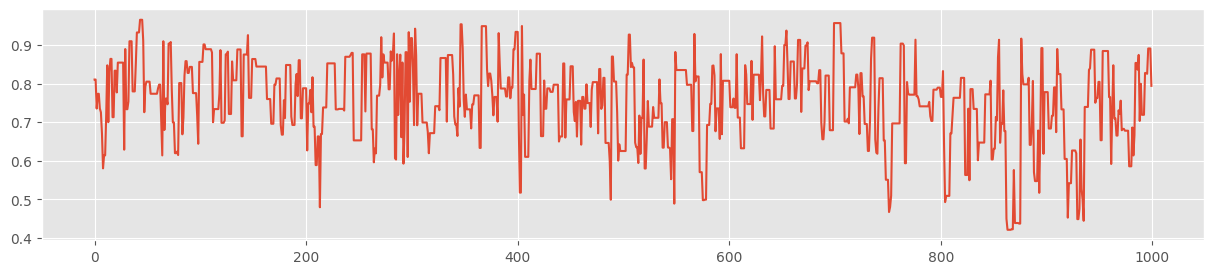

In [7]:
plt.plot( chain )

(looks ok - otherwise tune $\sigma$ as done in the next part)

#### Step 1 (hyperparameter tuning): Try out other values of sigma

  0%|          | 0/1000 [00:00<?, ?it/s]

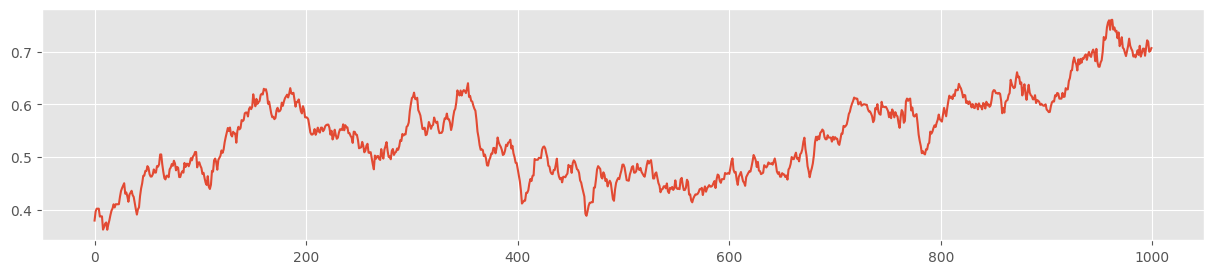

In [8]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.01 )
plt.plot( chain )

Example for slow mixing - sigma is too small and the chain explores the parameter space only slowly.

  0%|          | 0/1000 [00:00<?, ?it/s]

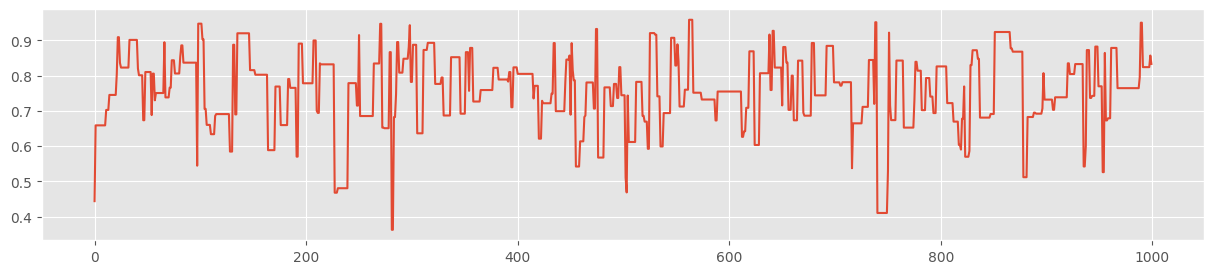

In [9]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.5 )
plt.plot( chain )

The chain is often stuck. High rejection rate because sigma is too large and most of the proposals land far away from the mass of the posterior.

`sigma = 0.2` seems more or less ok:

  0%|          | 0/1000 [00:00<?, ?it/s]

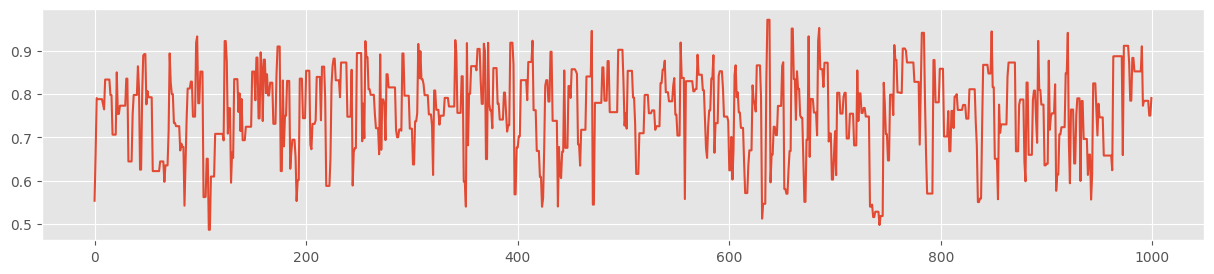

In [10]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

#### Step 2: Visualize distribution

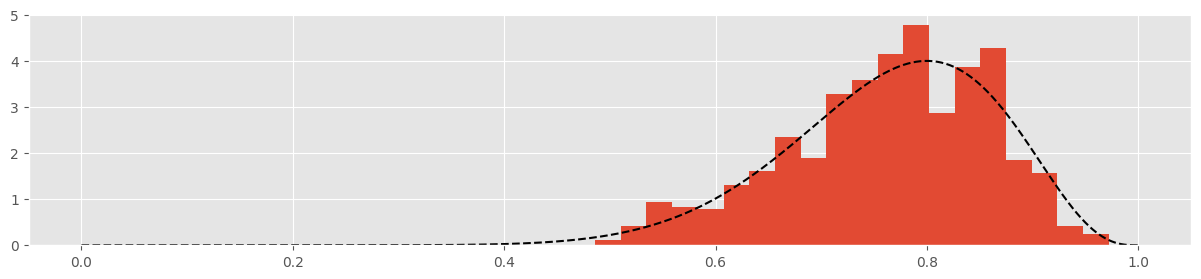

In [11]:
# histogram
plt.hist( chain, density=True, bins=20 )

# true posterior
pi_range = np.linspace(0, 1, 1000)
true_posterior = [stats.beta.pdf(pi, alpha+k, beta+n-k) for pi in pi_range]
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Seems more or less ok! Try with more samples:

  0%|          | 0/4000 [00:00<?, ?it/s]

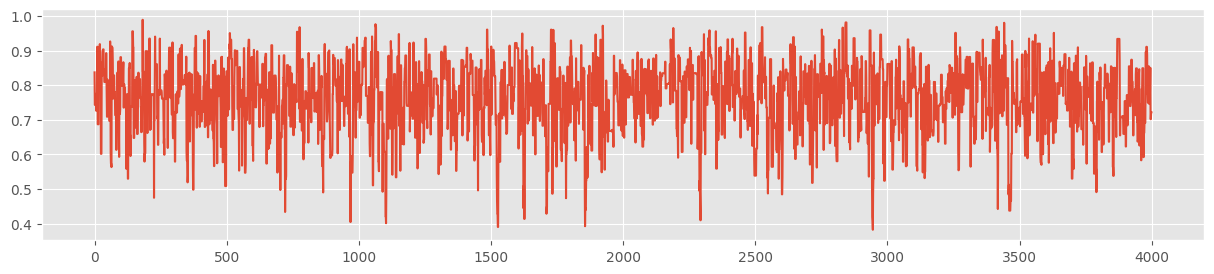

In [12]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

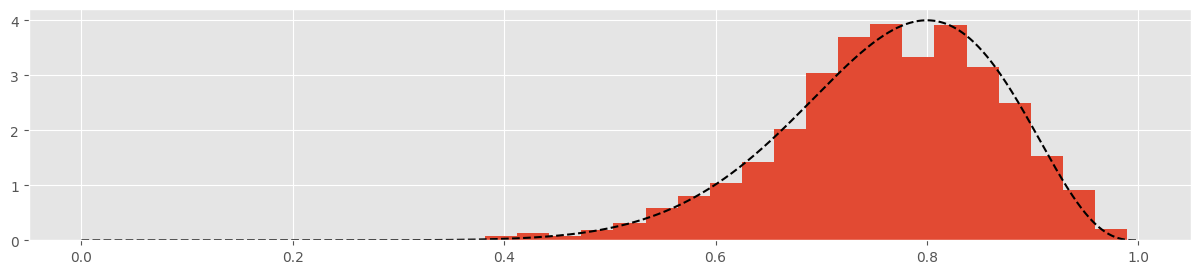

In [13]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Looks good!

### f) Playing around

#### `sigma` much too low:

  0%|          | 0/4000 [00:00<?, ?it/s]

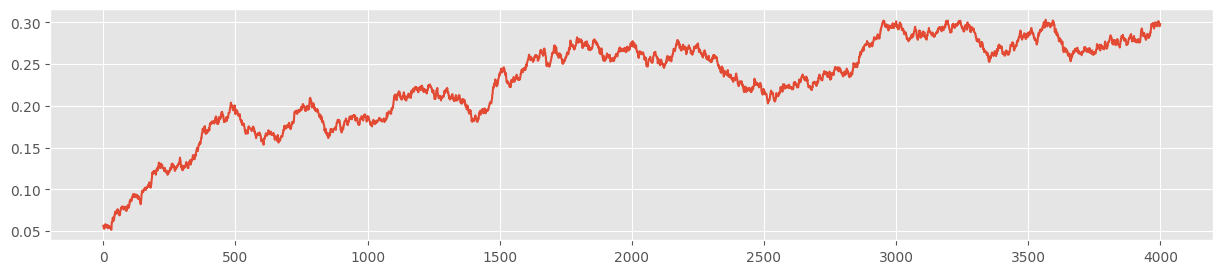

In [14]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.002 )
plt.plot( chain )

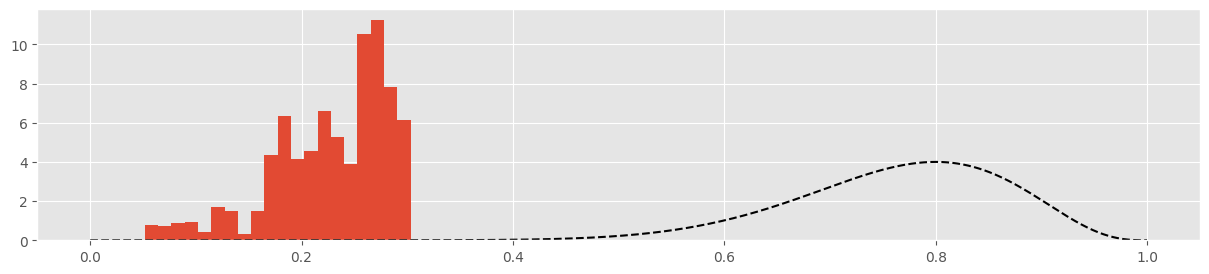

In [15]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Chain explores only a small part of the parameter space! Acceptance rate is very high because chain always climbs up towards the mode with very small steps. However it barely reaches it.

#### `sigma` much too high:

  0%|          | 0/4000 [00:00<?, ?it/s]

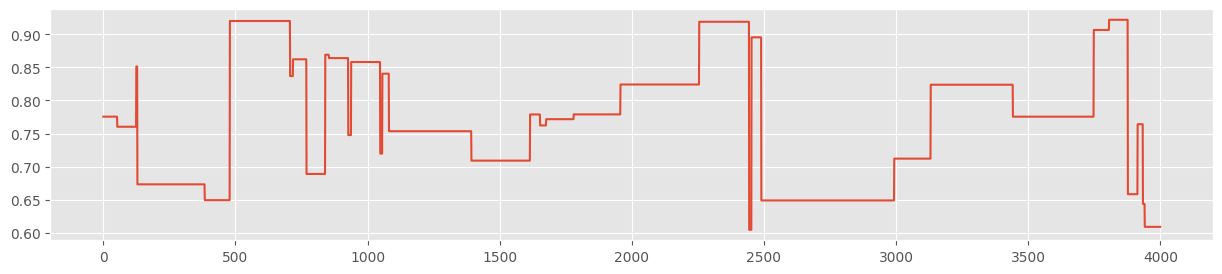

In [16]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=20 )
plt.plot( chain )

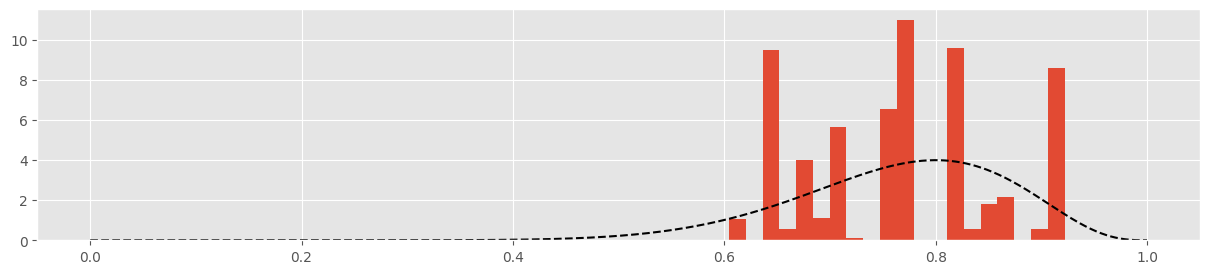

In [17]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Chain is mostly stuck at the same point and most of the proposals are rejected. Because of this, we only get a few independent samples and the density is concentrated and exaggerated around the points where the chain was stuck.

#### `sigma` just right:

  0%|          | 0/4000 [00:00<?, ?it/s]

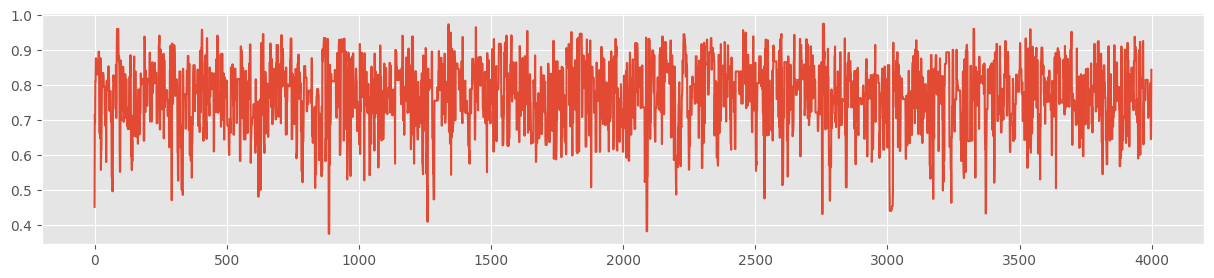

In [18]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

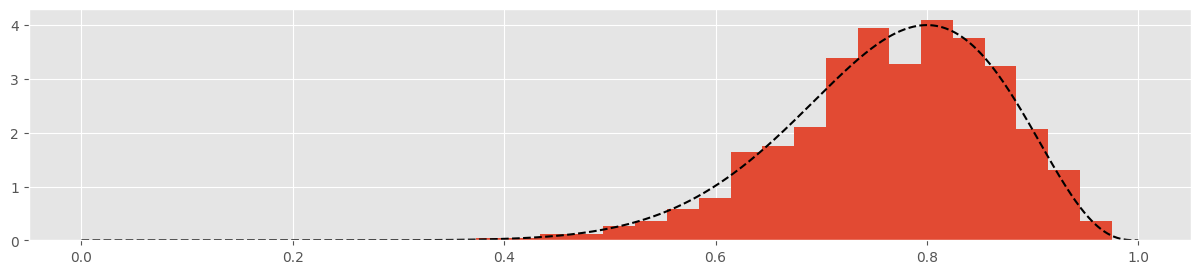

In [19]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

The trace plot looks completely random (not stuck, not creeping), the true distribution is approximated quite nicely.

## Exercise 2

### a) Multiple chains

In [20]:
def metropolis( n_chains, n_steps, alpha, beta, n, k, sigma ):
    res = [metropolis_chain( n_steps, alpha, beta, n, k, sigma ) for i in range( n_chains)]
    return np.array(res).T # to have chains in columns

sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )
sim.shape

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

(4000, 4)

### b) Trace plots

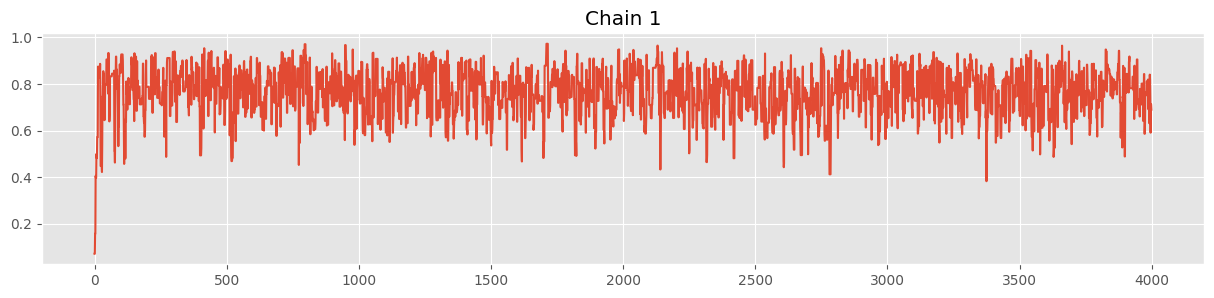

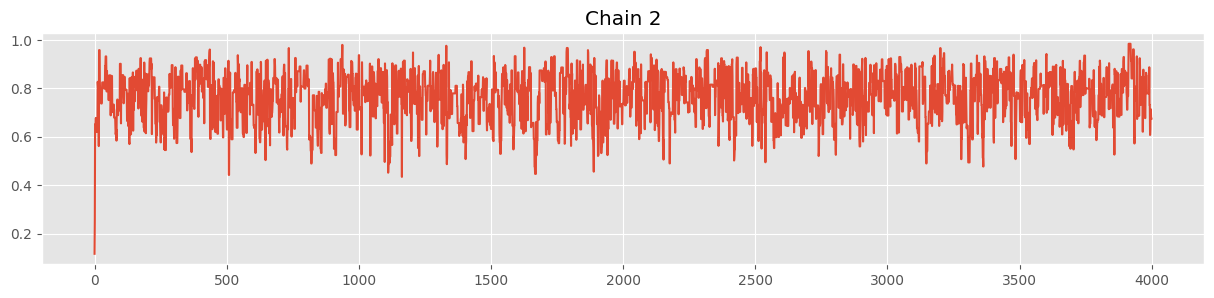

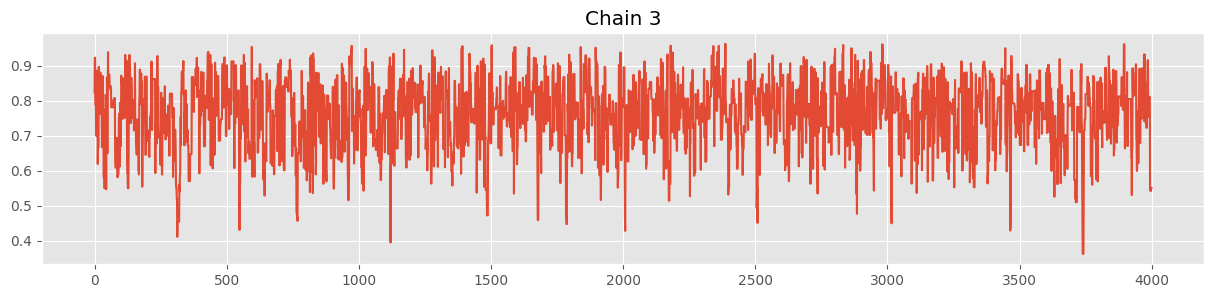

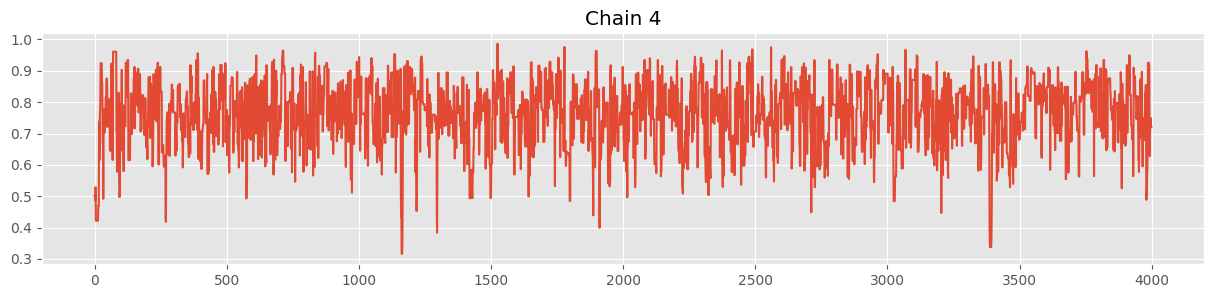

In [21]:
for i in range( sim.shape[1] ):
    plt.figure()
    plt.plot( sim[:,i] )
    plt.title("Chain {}".format(i+1))

Looks ok!

### c) Density plots

#### `sigma` just right:

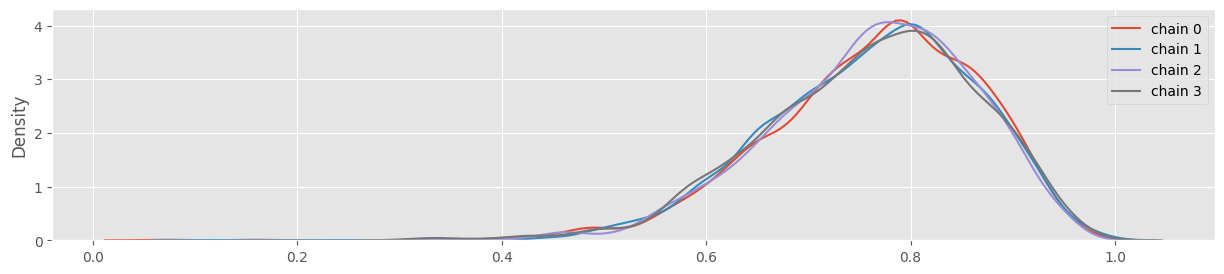

In [22]:
def density_plots( sim ):
    for i in range( sim.shape[1] ):
        sns.kdeplot( sim[:,i], label="chain {}".format(i) )
    plt.legend()

density_plots( sim )

Chains have converged quite well!

#### `sigma` too small:

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

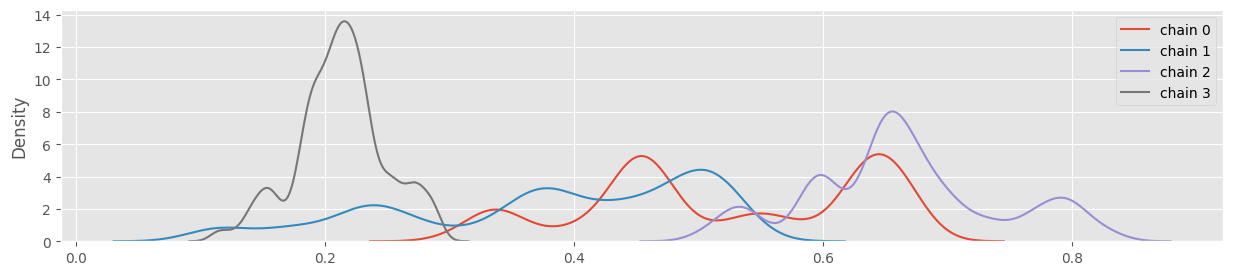

In [23]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.002 )
density_plots( sim )

Chains have not converged yet and explore different regions of the parameter space.

#### `sigma` too large:

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

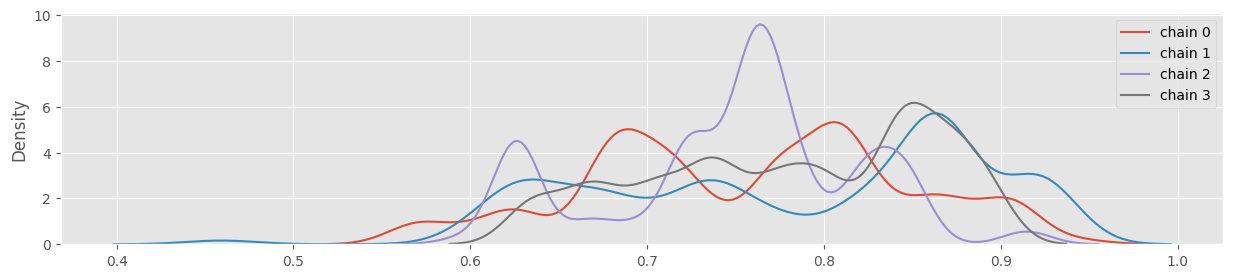

In [24]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=20 )
density_plots( sim )

Chains have not coverged - density plot is misleading, chains are stuck at single points.

### d) $\hat{R}$

In [25]:
def rhat( sim ):
    total_var = np.var( sim.flatten() )
    individual_var = np.var( sim, axis=0 )
    rhat = np.sqrt( total_var / np.mean(individual_var) )
    return rhat

sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )
rhat( sim )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

1.0003367756186425

Very close to 1, this is a sign for a healthy chain!

#### `sigma` too small:

In [26]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.002 )
rhat( sim )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

2.1929934550058863

Rhat is much larger than 1 - this is a sign for a very unhealthy chain!

#### `sigma` too large:

In [27]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=20 )
rhat( sim )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

1.0651792037581815

Rhat is quite small - however the chains have not converged well! Therefore Rhat alone cannot be used as a single diagnostic, evidence of the unhealthiness can only be found in the trace plot in this case (also an autocorrelation plot and effective sample size could be valuable tools here). 

### e) Burn-in phase

Let's come back to our healthy chain:

In [28]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Trace plot of first chain (only beginning):

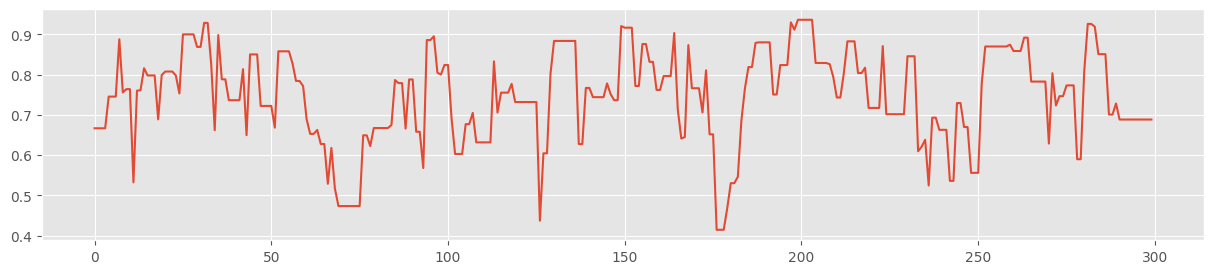

In [29]:
plt.plot( sim[:300,0] )

Since the beta-binomial posterior has a very smooth, one-dimensional probability surface, the Metropolis algorithm finds the mode quickly and appears to require only around 10 samples of burn-in time (depending on the initial value). In the overall size of the chain the burn-in phase can be neglected in this case. This is different for more complicated, multivariate problems!

## Exercise 3

### a)

In [30]:
import pymc as pm
with pm.Model() as beta_binom_model:
    pi = pm.Beta( 'pi', alpha=alpha, beta=beta )
    y = pm.Binomial( 'y', p=pi, n=n, observed=k )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


PyMC gives you 4 chains by default and is using the NUTS algorithm in this case.

### b)

The output of PyMC is an xarray object. Let's have a look at it:

In [31]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [32]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    pi       (chain, draw) float64 0.7679 0.6252 0.8504 ... 0.6095 0.7759 0.6378
Attributes:
    created_at:                 2025-09-24T17:23:36.341928+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.0
    sampling_time:              1.285285472869873
    tuning_steps:               1000

In [33]:
sim = trace.posterior.pi.values
sim.shape

(4, 1000)

This gets us back the values in the chain we produced previously.

### c)

Trace and density plot:

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

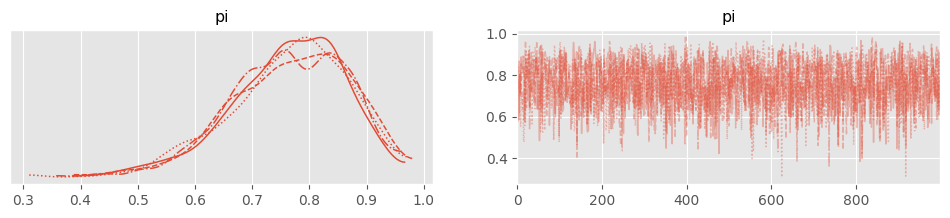

In [34]:
pm.plot_trace( trace )

Autocorrelation plot (all chains combined):

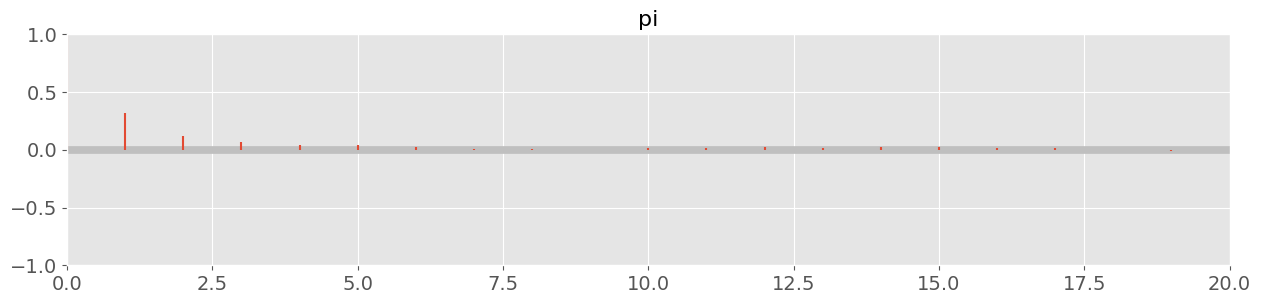

In [35]:
pm.plot_autocorr( trace, combined=True, max_lag=20 );

Drops off extremely quickly!

Effective sample size (ESS):

In [36]:
ess = pm.ess( trace ).pi.values
ess

array(1638.31679614)

Considerably lower than 4000! ESS ratio:

In [37]:
ess / 4000

0.4095791990355344

Much larger than the required 10%!

Rhat:

In [38]:
pm.rhat( trace ).pi.values

array(1.00090821)

Looks good! (<< 1.05)

Model graph:

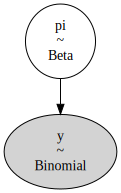

In [39]:
pm.model_to_graphviz( beta_binom_model )

Arrow: the likelihood Bin$(Y=y|\pi)$ depends on $\pi$ (that is modelled by a prior).

### d)

array([[<Axes: title={'center': 'pi'}>,
        <Axes: title={'center': 'pi'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

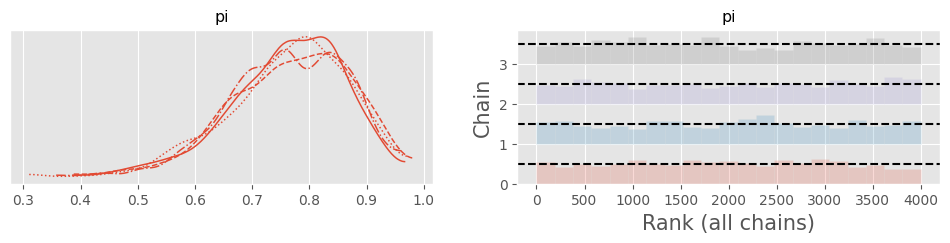

In [40]:
pm.plot_trace( trace, kind="rank_bars" )

The rank (or trank) plot does the following: 
1. Rank the samples from all chains from 1 to 4000 (number samples used here)
2. For each chain individually, produce a histogram of its ranks

For healthy, well-mixing chains, the histograms should be uniform. A spike indicates that the chain got stuck somwhere (producing too many samples of one particular value of $\pi$. Any other asymmetries indicate that the chains did not explore the same regions of the parameter space.

The rank plot above looks good!

More details: Vehtari, Gelman, Simpson, Carpenter, Bürkner. 2019. Rank-normalization, folding, and localization: An improved R-hat for assessing convergence of MCMC. https://arxiv.org/abs/1903.08008

### e)

Plot truncated normal prior:

<Axes: >

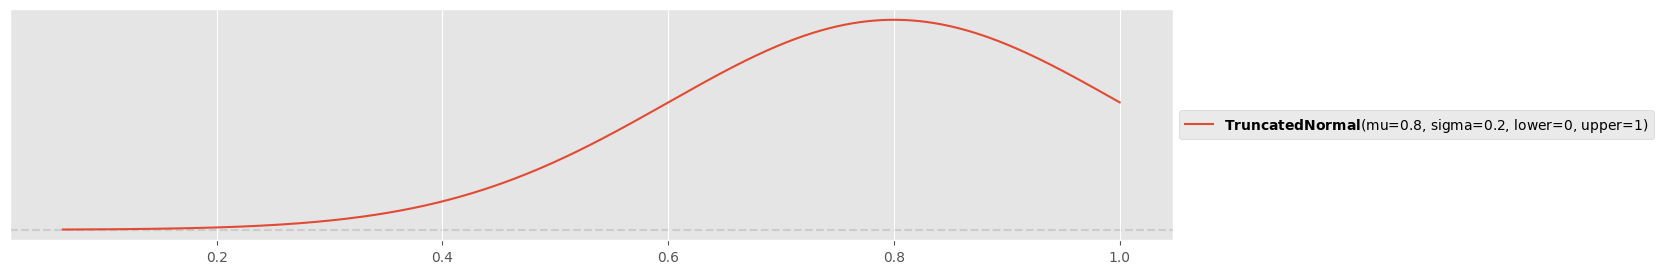

In [41]:
pz.TruncatedNormal( mu=0.8, sigma=0.2, lower=0, upper=1 ).plot_pdf()

Plot previous prior:

<Axes: >

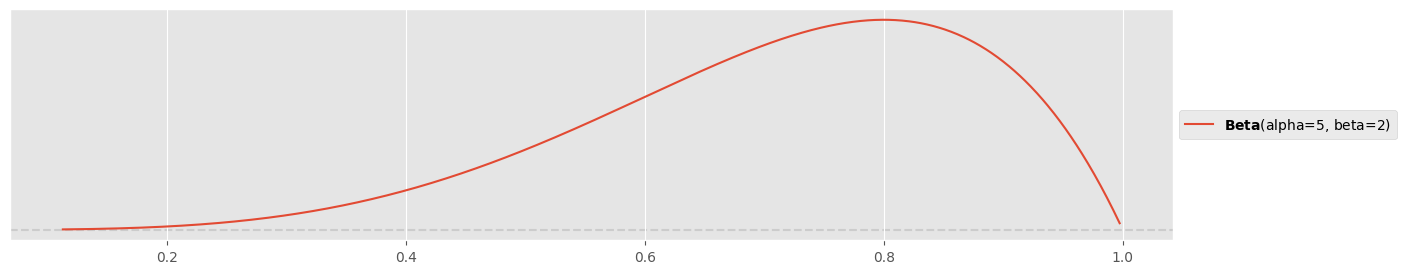

In [42]:
pz.Beta( alpha=alpha, beta=beta ).plot_pdf()

Run simulation with truncated normal prior:

In [43]:
with pm.Model() as normal_binom_model:
    pi = pm.TruncatedNormal( 'pi', mu=0.8, sigma=0.2, lower=0, upper=1 )
    y = pm.Binomial( 'y', p=pi, n=n, observed=k )
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Compare densities:

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

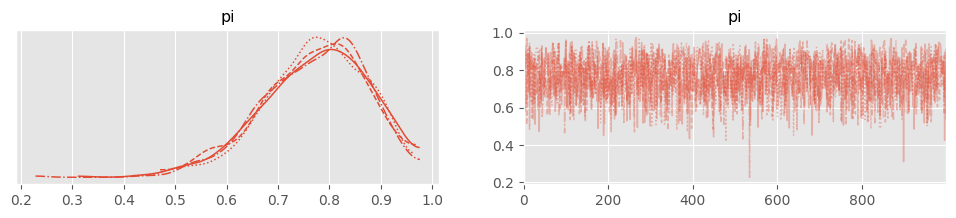

In [44]:
pm.plot_trace( trace2 )

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

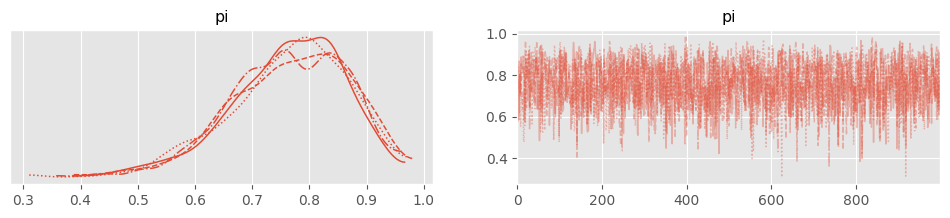

In [45]:
pm.plot_trace( trace )

Compare summaries:

In [46]:
pm.summary( trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.77,0.1,0.585,0.947,0.002,0.002,1644.0,2157.0,1.0


In [47]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.764,0.102,0.577,0.943,0.002,0.002,1638.0,2457.0,1.0


The resulting densities are very similar! It appears that the simulation with the truncated normal prior is numerically a bit less effective, with $\sim400$ less effective samples both in the bulk (center of the distribution) and the tails (periphery). This means that the beta prior produces more accurate estimates at the same computational effort!

## Exercise 4

### a)

<Axes: >

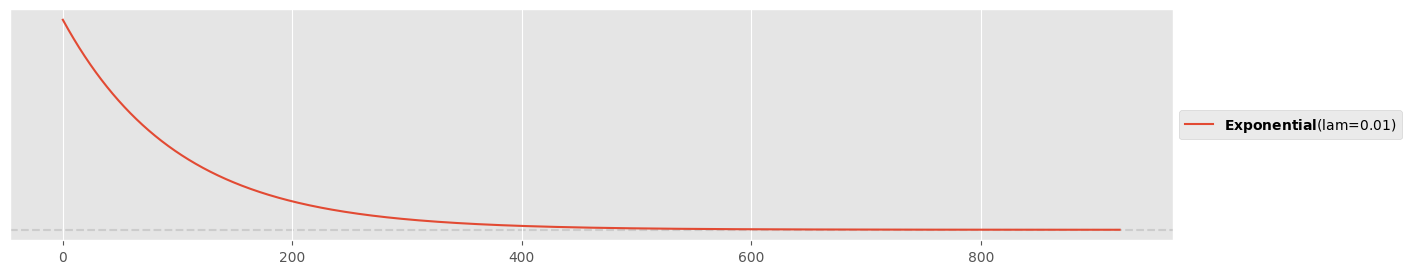

In [48]:
pz.Exponential(1/100).plot_pdf()

In [49]:
pz.Exponential(1/100).mean()

100.0

If $\sigma \sim \text{Exp}(1/\lambda)$, then $E[\sigma] = \lambda$ (see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Exponential_distribution)). Since the exponential distribution is right-skewed, prior values below $100^\circ$ C are favored to values above $100^\circ$ C. 

A normal distribution can't be used as prior for $\sigma$, since it could also produce negative values, and $\sigma$ is strictly positive. A beta distribution is restricted to values between 0 and 1 and $\sigma$ is most likely not. The exponential distribution suits well here, as it produces positive numbers.

### b)

In [50]:
observations = [1055, 1053, 1226,  967,  980, 1049, 1040, 1051, 1002, 1057]

with pm.Model() as normal_normal_model:
    mu = pm.Normal( 'mu', mu=1000, sigma=100 )
    sigma = pm.Exponential( 'sigma', 1/100 )
    y = pm.Normal( 'y', mu=mu, sigma=sigma, observed=observations )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


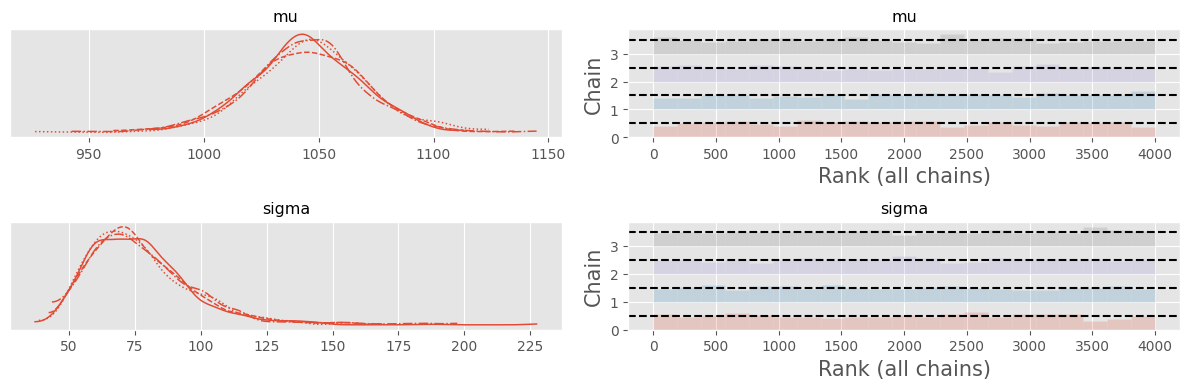

In [51]:
pm.plot_trace( trace, kind="rank_bars" )
plt.tight_layout()

Looks good!

In [52]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1044.962,24.437,1000.983,1093.807,0.464,0.328,2852.0,2165.0,1.0
sigma,77.111,20.083,45.367,112.127,0.398,0.294,2807.0,2582.0,1.0


Your understanding of mean maximum temperature increased from $\mu=1000$ to $\mu=1046$, while your understanding of uncertainty $\sigma$ on this mean maximum temperature decreased from $\sigma=100^\circ$ C to $\sigma=78^\circ$ C.

### c)

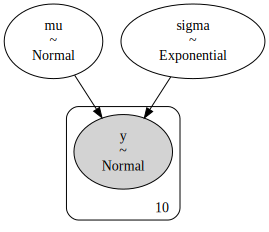

In [53]:
pm.model_to_graphviz( normal_normal_model )

### d)

Extract Numpy arrays for mu and sigma:

In [54]:
mu_chain = trace.posterior.mu.values
sigma_chain = trace.posterior.sigma.values
mu_chain.shape, sigma_chain.shape

((4, 1000), (4, 1000))

2D plot of parameter space:

Text(0, 0.5, '$\\sigma$')

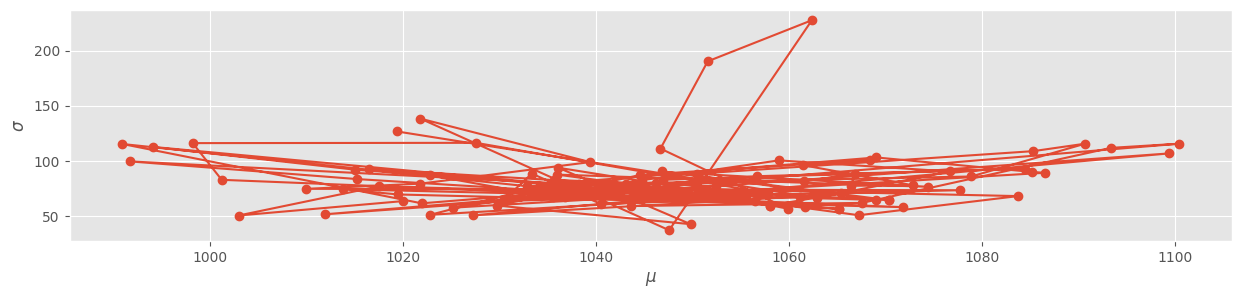

In [55]:
plt.plot( mu_chain[0,:100], sigma_chain[0,:100], marker="o" )
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")

The warm-up phase can clearly be located away from the mode!